<a id="top8"></a>
# Convolutional Neural Network

- [1. Getting MFCCs data](#part8a)
- [2. ConvNet model and evaluation](#part8b)
- [3. Confusion matrix](#part8c)

#### Import dataframe with transformed features

Let's import the dataset previously exported and extract `X` feature matrix and `y` numerical target:

In [1]:
# import libraries
import pandas as pd
import numpy as np
import librosa
import librosa.display
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # to avoid TensorFlow compiler flag message

# Import the dataset and verify that the upload is successful
df = pd.read_csv('emotions_data_transformed.csv')
print('The dataset has {} audio files'.format(df.shape[0]))
df.sample()

The dataset has 9291 audio files


,path,filename,dataset,duration,gender,age,emotion,f0_mean,f0_median,f0_std,...,mfcc21_var,mfcc22_var,mfcc23_var,mfcc24_var,mfcc25_var,mfcc26_var,mfcc27_var,mfcc28_var,mfcc29_var,mfcc30_var
84,../Audio files/TESS/OAF_sheep_angry.wav,OAF_sheep_angry,TESS,1.675,female,64,0,5.597713,5.596622,3.075264,...,5.820543,6.487921,6.697929,5.974446,6.362917,6.259417,5.681104,4.778309,4.765688,206.44957


### <a id='part8a'>1. Getting MFCCs data</a>

As the first step for this task, I will need to extract the MFCCs information from the audio files. I chose to obtain 30 components for each sample, which will create a 2D image with the sound characteristics of the files.

In [2]:
%%time

# Create a variable where to store the mfccs data
mfccs = []

for file in df.path:
    # load audio file:
    y, sr = librosa.load(file, sr=16000)
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    mfccs.append(librosa.feature.mfcc(y, sr=sr, fmin=50, n_mfcc=30))

CPU times: user 32min, sys: 5min 44s, total: 37min 44s
Wall time: 11min 12s


Since the samples have different durations, I need to reshape these two-dimensional arrays in order to feed correctly to the convolutional model. For this reason, I created a function to have the files to the same shape of 30x200, which corresponds to about 6 seconds of audio. This also means that files that are shorter will have an additional silent part to reach this threshold (zeros padding), while longer files will be cut off.

In [3]:
# Define function to resize the 2D arrays
def resize_array(array):
    new_matrix = np.zeros((30,200))   # Initialize the new matrix shape with an array 30X200 of zeros
    for i in range(30):               # Iterate rows
        for j in range(200):          # Iterate columns
            try:                                 # the mfccs of a sample will replace the matrix of zeros, then cutting the array up to 200
                new_matrix[i][j] = array[i][j]
            except IndexError:                   # if mfccs of a sample is shorter than 200, then keep looping to extend lenght to 200 with 0s
                pass
    return new_matrix

# Create a variable to store the new resized mfccs and apply function for all the extracted mfccs
resized_mfccs = []

for mfcc in mfccs:
    resized_mfccs.append(resize_array(mfcc))

Let's visualize few MFCCs with the new shape:

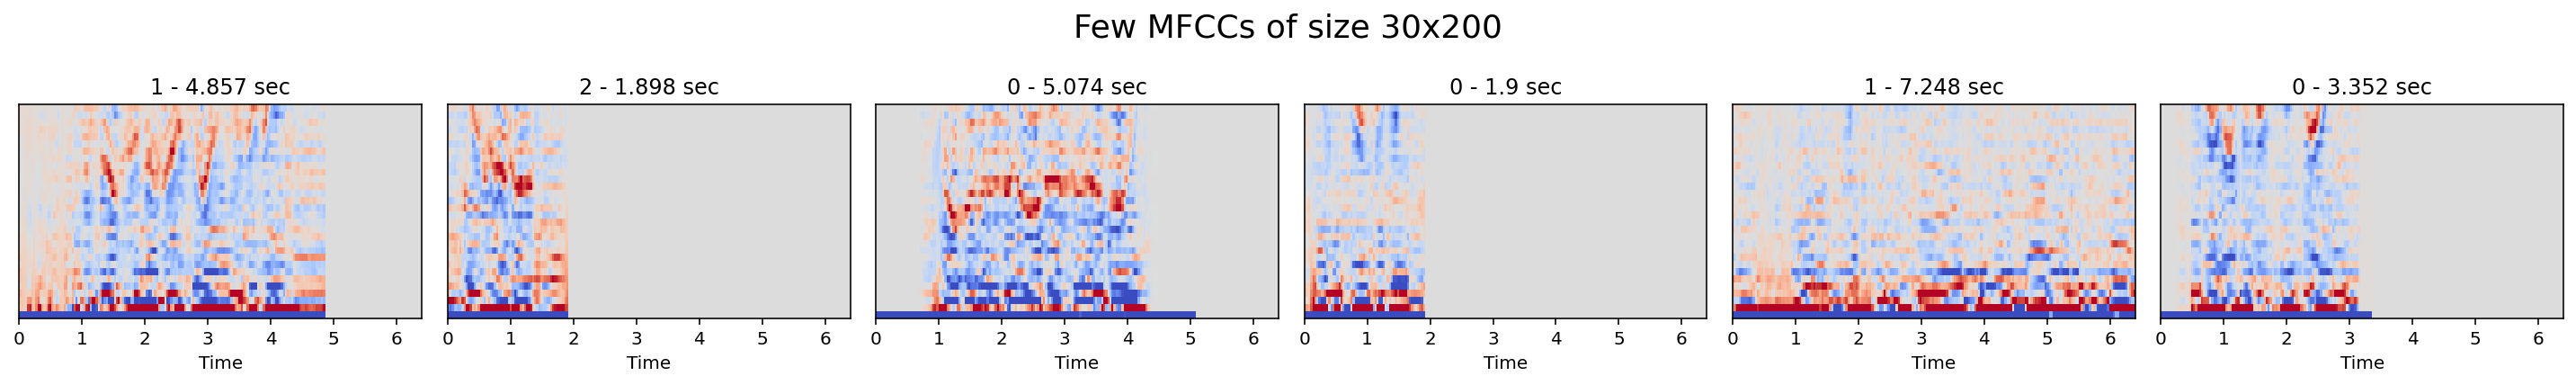

In [4]:
# Create sublots
fig, axs = plt.subplots(nrows=1,ncols=6, figsize=(20,3))

# Import normalize function to improve readibility
from matplotlib.colors import Normalize

# Select 6 random MFCCs
for i in range(6):
    index = random.randint(0, len(resized_mfccs))
    
    # Plot MFCCs
    librosa.display.specshow(resized_mfccs[index], sr=sr, x_axis="time", ax=axs[i], norm=Normalize(vmin=-50, vmax=50))
    axs[i].set_title(str(df.emotion[index]) + ' - ' + str(df.duration[index]) + ' sec')

plt.suptitle('Few MFCCs of size 30x200', size=18)
plt.tight_layout()
plt.show()

The reshaping function worked as expected, cutting the MFCC spectrum of the longer samples to ~6 seconds and adding silence for the shorter files to reach the same length.

### <a id='part8b'>2. Convolutional Neural Network model and evaluation</a>

Let's split the data into train, validation and test set:

In [5]:
from sklearn.model_selection import train_test_split

# Select target
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
y = df.emotion.values

# Features
X = resized_mfccs.copy()

# Create train, validation and test set
x_tr, x_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y, random_state=0)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.3, shuffle=True, stratify=y_tr, random_state=0)

# Convert data to numpy arrays
x_tr = np.array([i for i in x_tr])
x_va = np.array([i for i in x_va])
x_te = np.array([i for i in x_te])

# Plot size of dataset
print(x_tr.shape)
print(x_va.shape)
print(x_te.shape)

(5852, 30, 200)
(2509, 30, 200)
(930, 30, 200)


The data also should be scaled in order to be used properly in a convolutional neural network. This transformation can be done manually by applying the mean and standard deviation from the training set also to the other sets.

In [6]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

Another necessary operation is to add another 'dimension' to the data:

In [7]:
# Add the 'channel' dimension to the MFCCs spectrum input 'images'
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (5852, 30, 200) before the manipulation.
x_tr has a dimension of (5852, 30, 200, 1) after the manipulation.


Let' build the model:

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D)
from tensorflow.keras import initializers

# Create convolutional neural network and return summary
model = keras.Sequential()
model.add(Conv2D(filters=256, kernel_size=5, strides=(2, 2), activation="relu", input_shape=x_tr.shape[1:]))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=4, strides=(2, 1), activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 98, 256)       6656      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 49, 256)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 49, 256)       1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 46, 128)        524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 23, 128)       0         
 2D)                                                             
                                                        

Before fitting the model I will provide the `class_weights` due to the imbalanced classed, and an `EarlyStopping` callback function.

In [9]:
# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_tr), y= y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

Fit the model:

In [10]:
%%time

#  Trains the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb],
    class_weight=class_weights,
)

Epoch 1/100
183/183 [==============================] - 37s 199ms/step - loss: 2.0889 - accuracy: 0.3002 - val_loss: 2.0123 - val_accuracy: 0.1825
Epoch 2/100
183/183 [==============================] - 38s 208ms/step - loss: 1.4537 - accuracy: 0.4327 - val_loss: 1.3042 - val_accuracy: 0.4731
Epoch 3/100
183/183 [==============================] - 37s 205ms/step - loss: 1.2662 - accuracy: 0.5157 - val_loss: 0.9416 - val_accuracy: 0.6218
Epoch 4/100
183/183 [==============================] - 38s 205ms/step - loss: 1.0756 - accuracy: 0.6044 - val_loss: 0.7270 - val_accuracy: 0.7549
Epoch 5/100
183/183 [==============================] - 37s 201ms/step - loss: 0.9615 - accuracy: 0.6550 - val_loss: 0.6707 - val_accuracy: 0.7561
Epoch 6/100
183/183 [==============================] - 36s 198ms/step - loss: 0.8737 - accuracy: 0.6828 - val_loss: 0.6891 - val_accuracy: 0.7489
Epoch 7/100
183/183 [==============================] - 36s 197ms/step - loss: 0.8146 - accuracy: 0.7010 - val_loss: 0.6060 -

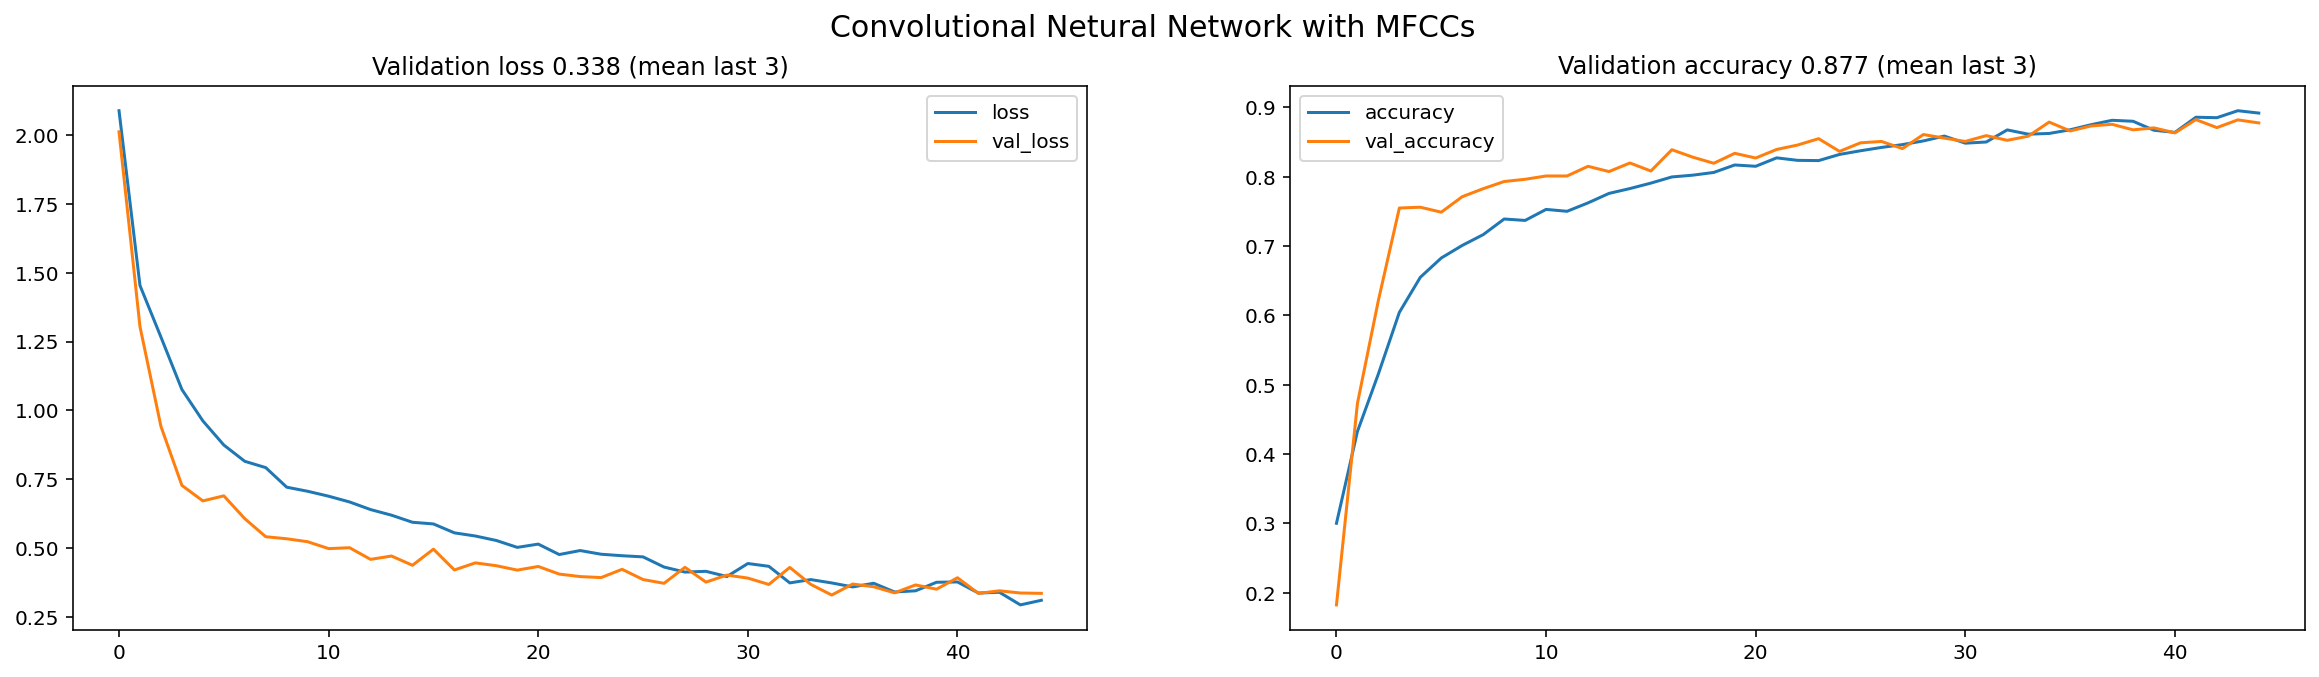

In [11]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.show()

The training and validation accuracies are both improving during the first 25 epochs, then we start to see signals of overfitting.

In [12]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

30/30 [==============================] - 1s 49ms/step - loss: 0.3140 - accuracy: 0.8849
Test loss: 0.31
Test accuracy: 88.49%


### <a id='part8c'>3. Confusion matrix</a>

30/30 [==============================] - 2s 49ms/step


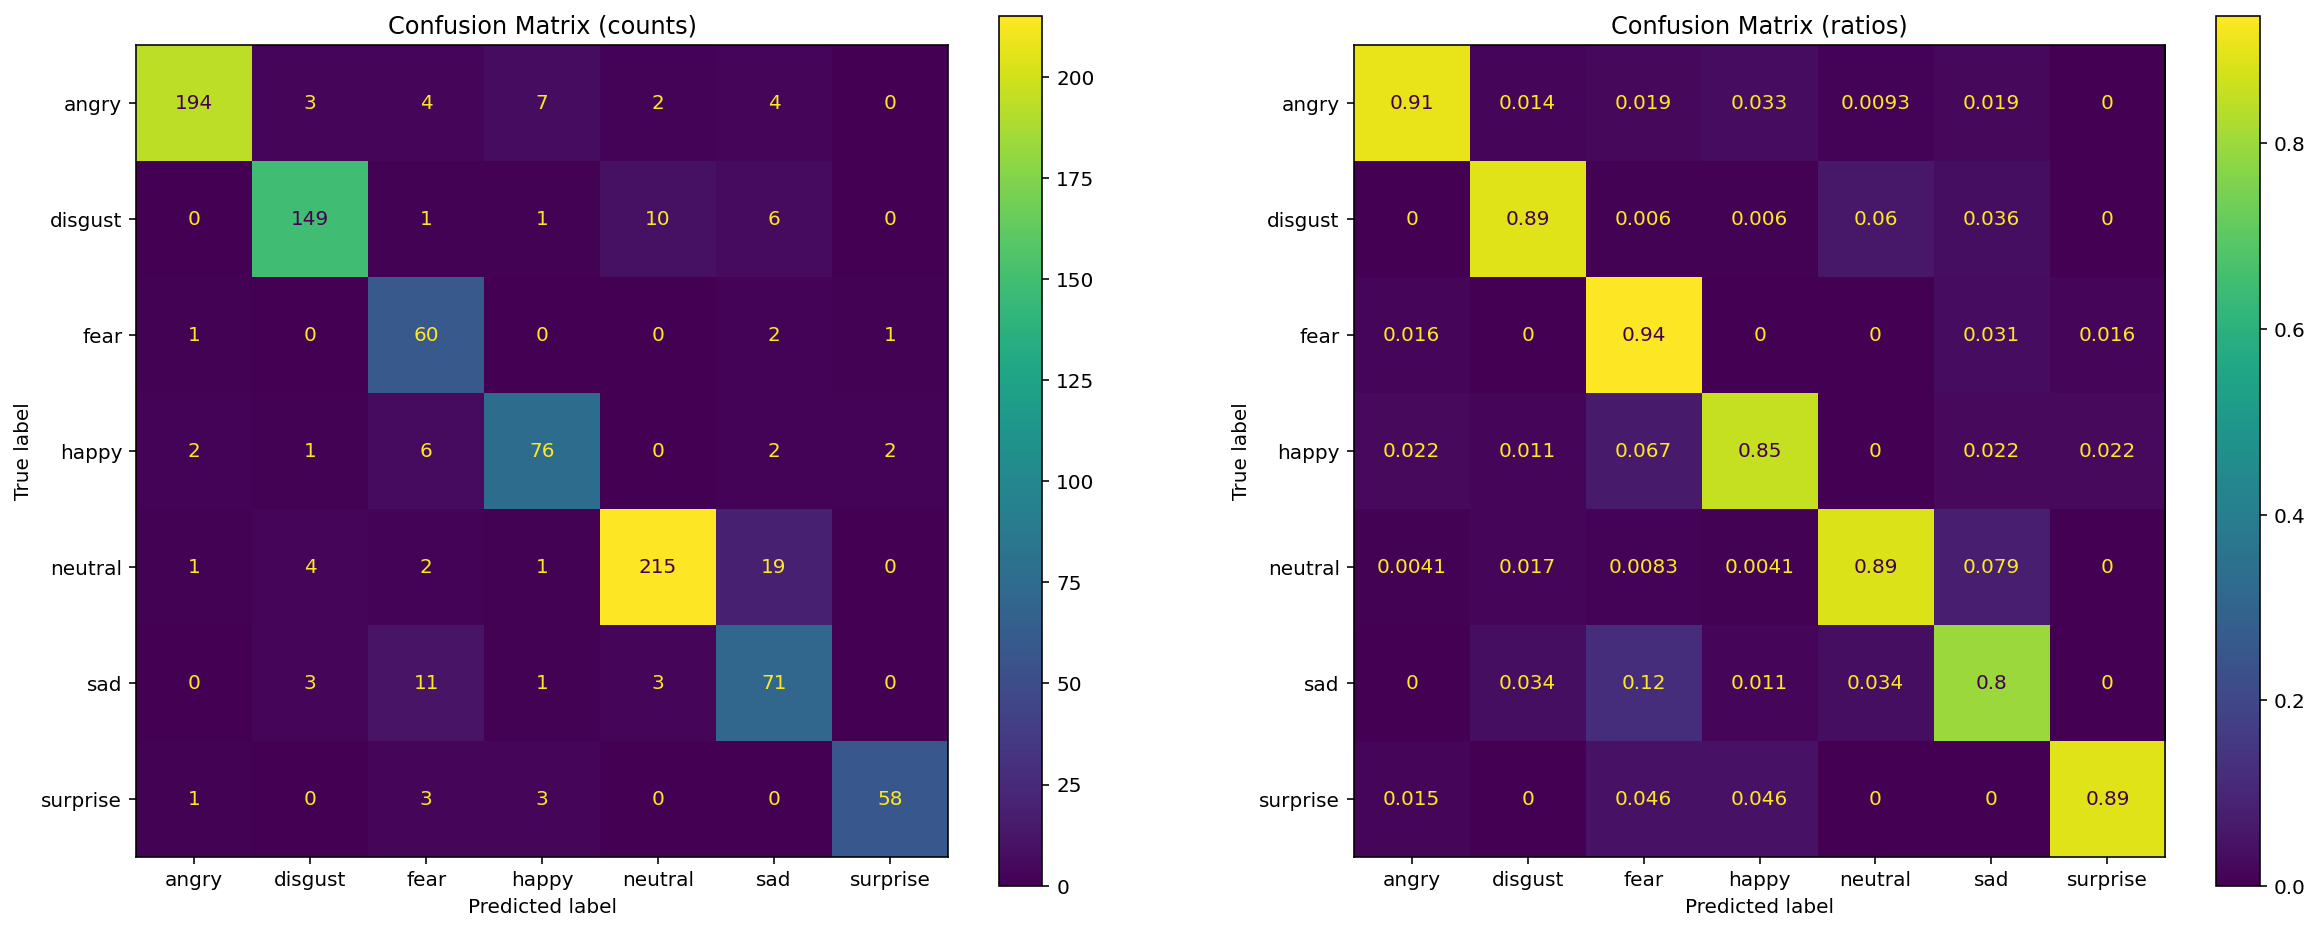

In [13]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)

- The best predictions occurred for the `angry` and `fear` categories
- The worst for the `happy` and `sad` emotions

<br>[Back to top](#top8)